# Math 210 Project I

## Linear Programming and Root Finding with `scipy.optimize`



---------
SciPy is one of the core scientific computing packages in Python and the subpackage `scipy.optimize` provides several commonly used optimization algorithms such as (see the [documentation](https://docs.scipy.org/doc/scipy-0.18.1/reference/optimize.html#module-scipy.optimize)):

1. Scalar univariate functions minimizers and root finders 
2. Least-squares minimization and curve fitting algorithms 
3. Global and local optimization routines 
4. Uncontrained and constrained minimization of multivariate scalar functions 
5. Multivariate equation system solvers 


**Our goal** in this notebook is to explore **two functions** in the subpackage `scipy.optimize`. One function is **`linprog`** which **finds the optimum outcome (such as maximum profit and lowest cost) in a model which constraints are linear**. The other function is **`fsolve`** which **solves for each root of a scalar function given a starting estimate**. In particular, linear programming is used in various fields of study to model problems in planning, scheduling, assignment and design. Therefore, we will spend a lot of time introducing the set up of linear programming problems and exploring interesting linear programming applications such as **nut sampling** and **meat production**. 

There are also many other applications of linear programming include energy,transportation,manufacturing, etc, and some of the great applications such as **USB manufacturing**, **gas blending** and **pig farming** are provided at the very end of this notebook for readers to practice with. By the end of the notebook, the reader will be able to implement the following functions: 

* scipy.optimize.lingprog (see the [documentation](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.linprog.html#scipy.optimize.linprog))
* scipy.optimize.fsolve (see the [documentation](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html#scipy.optimize.fsolve))


## Contents 

1. Linear Programming:
   * Application: Nut Sampling
   * Application: Meat Production
2. Root Finding 
4. Exercises 
5. Additional Resources

### Import SciPy, NumPy and Matplotlib

This project requires an import of `scipy.optimize`, numpy and matplotlib.pylot packages into our workspace.

In [2]:
import scipy.optimize as opt
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

## 1. Linear Programming 

### Standard Form of a Linear Program
   [Linear Programming](https://en.wikipedia.org/wiki/Linear_programming) is a **linear optimization** technique which is used to find maxima and minima of linear functions of several variables subject to constraints that are linear inequalities or linear equations. This optimization method is powerful in modeling a variety of problems in scheduling and design, and in fact the word "programming" itself has the old-fashioned meaning of "planning". It is widely used in economics, business and many other industries in areas such as manufacturing, game theory, nutrition balancing and  stock cutting.
   
   A linear program (LP) is typically expressed in a fixed format called the **standard form**, which looks like:
   
   $$ \mathrm{Maximize} \ \ c_1x_1+c_2x_2+\dots+c_nx_n$$
   $$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \mathrm{subject \ to} \ \ a_{11}x_1+a_{12}x_2+\dots+a_{1n}x_n \leq b_1$$
   $$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  a_{21}x_1+a_{22}x_2+\dots+a_{2n}x_n \leq b_2$$
   $$\vdots$$
   $$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ a_{m1}x_1+a_{m2}x_2+\dots+a_{mn}x_n \leq b_m$$
   $$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ x_1, x_2,\dots, x_n \geq 0 $$
   
   
   We can also rewrite the LP in [canonical form](https://en.wikipedia.org/wiki/Canonical_form) by setting: 
   * $\textbf{x}=(x_1,x_2,\dots,x_n)^\mathrm{T}$
   * $\textbf{c}=(c_1,c_2,\dots,c_n)^\mathrm{T}$
   * $\textbf{b}=(b_1,b_2,\dots,b_m)^\mathrm{T}$, and
   * $ A=\begin{pmatrix} a_{11}&a_{12}&\dots&a_{1n} \\ a_{21}&a_{22}&\dots&a_{2n} \\ \vdots& \vdots& \ddots &\vdots \\
       a_{m1}&a_{m2}&\dots&a_{mn} \end{pmatrix}$
  

With those definitions, we can now write the LP as: 
 
   $$ \mathrm{Maximize} \ \textbf{c}^\mathrm{T}\textbf{x}$$
   $$ \ \ \ \ \ \ \mathrm{subject \ to} \ \ A\textbf{x}\leq \textbf{b}$$
   $$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \textbf{x} \geq 0$$
   

### Characteristics of standard form LPs

**Rule 1**: The standard form LP is about **maximizing**, not minimizing 

**Rule 2**: There is a positivity constraint for each variable ($x_i \geq 0$ for all $i$)

**Rule 3**: The other constraints are all of the form "linear combination of variables $\leq$ constant"

### Converting a LP to its standard form 
We can convert any LP into its equivalent LP in standard form, or the other way around. There are many "errors" that you need to fix such as a variable lacks a positivity constraint (violates **Rule 2**) or a constraint is an equality (violates **Rule 3**). However, those "errors" are unrelated to this project so we are not going to introduce them here. You can read this [documentation](http://mat.gsia.cmu.edu/classes/QUANT/NOTES/chap7/node3.html) for more information about conversion on your own. Here, we just need to know several conversion rules before we can begin using `scipy.optimize.linprog`:

**1. The objective function is to be minimized**

This is a violation to **Rule 1** and it is easy to change. Minimizing $c_1x_1+c_2x_2+\dots+c_nx_n$ is the "same" as maximizing $-c_1x_1-c_2x_2-\dots-c_nx_n$. The maximum value of the new objective function is just **minus** the minimum value of the old objective function, and the values of the other variables that lead to the optimum stay the same.

**2. Constraints are lower bound**

This is a violation to **Rule 3** and it is also easy to fix. We just need to replace $a_{i1}x_1+a_{i2}x_2+\dots+a_{in}x_n \geq b_i$ with $-a_{i1}x_1-a_{i2}x_2-\dots-a_{in}x_n \leq -b_i$. Notice that this does not change the values of $x_j$ that satisfy the constraints.

Now, we can start introduce the the function `linprog`:

### `scipy.optimize.linprog`

The function `linprog` **minimizes** a linear objective function subject to constraints that are either linear equations or linear inequalities. It is intended to be used to solve linear programs in the form of: 
$$ \mathrm{Minimize} \ \textbf{c}^\mathrm{T}\textbf{x}$$
$$ \ \ \ \ \ \ \ \ \ \ \ \ \mathrm{subject \ to} \ A_{ub} \textbf{x} \leq \mathbf{b_{eq}}$$

Notice that this form doesn't include any positivity constraints for **x**  (so no Rule 2), and this is a special feature of `linprog` where the bounds on **x** can be set explicitly. As you can see, `linprog` is used to solve problems that **deviate from** the standard LP problems because it is about **minimizing**, not maximizing. The first parameter of `linprog` is the vector **c**, which represents the coefficients of the linear objective function to be minimized. All the other inputs are optional. However typically to solve an LP, we also need the second input $\mathbf{A_{ub}}$ which is a 2-D array that is matrix-multiplied by **x** to give values of the **upper-bound** inequality constraints. This follows the standard LP problem assumption that the constraints are all of the form "linear combination of variables $\leq$ constant" (so Rule 3 is satisfied). Also, we need the third input $\mathbf{b_{eq}}$ which is a 1-D array that represents the values on the right hand side of the constraints. 

In this project, we don't need to make any changes to the parameter 'bounds' since the default follows from the standard form LPs. The assumption that all variables must be non-negative is satisfied here (so Rule 2 is satisfied). However, the function `linprog` can also give non-standard bounds to the variables **x**. In that case, the bounds of the variables need to be set explicitly. You can check out the [documentation](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.linprog.html#scipy.optimize.linprog) to learn more about the parameters of `linprog`.

Since linear programming is widely used to model different types of problems in various fields of study, it will be interesting to take a look at some applications of the function `linprog`.

## Example: Nuts Sampling

![Nuts Sampling](http://www.bekrdaneh.ir/UserFiles/image/mixed-nuts.jpg)

Consider an industry which sells nut samplers. A food seller packages a nut sampler consisting of walnuts, pecans, and almonds. Suppose each ounce of walnuts contains 12 units of protein and 3 units of iron and costs 12 cents, each ounce of pecans contains 1 unit of protein and 3 units of iron and costs 9 cents, and each ounce of almonds contains 2 units of protein and 1 unit of iron and costs 6 cents. If each package of the nut sampler is to contain at least 24 units of protein and at least 18 units of iron, how many ounces of each type of nut should be used to **minimize** the cost of the sampler? 

#### Step 1: Define the variables 

Let $\mathbf{x_1}$= Walnuts, $\mathbf{x_2}$= Pecans and $\mathbf{x_3}$=Almonds.

#### Step 2: Set up the LP
We want to write this problem as the following linear program:

$$ \mathrm{Minimize} \ \ 12x_1+9x_2+6x_3$$
   $$ \ \ \ \ \ \ \mathrm{subject \ to} \ \ 12x_1+x_2+2x_3 \geq 24$$
   $$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  3x_1+3x_2+x_1 \geq 18$$
   $$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ x_1, x_2, x_3 \geq 0 $$


#### Step 3: Conversion
Notice that this LP problem is about **minimizing** so we can use the function `linprog` directly. However in order to use `linprog`, the constraints need to be upper bounds before we can begin. Here, the constraints are **NOT** upper bounds so we need to replace the constraints $a_{i1}x_1+a_{i2}x_2+\dots+a_{in}x_n \geq b_i$ with $-a_{i1}x_1-a_{i2}x_2-\dots-a_{in}x_n \leq -b_i$ for any  $i$. The new LP after conversion is:


$$ \mathrm{Minimize} \ \ 12x_1+9x_2+6x_3$$
   $$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \mathrm{subject \ to} \  \mathbf{-12x_1-x_2-2x_3 \leq -24}$$
   $$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \mathbf{-3x_1-3x_2-x_1 \leq -18}$$
   $$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ x_1, x_2, x_3 \geq 0 $$


#### Step 4: Define all the parameters of `linprog`

Now we are good to go. Set the parameters from the LP as

* $\textbf{c}=(12,9,6)^\mathrm{T}$
* $\textbf{b}=(-24,-18)^\mathrm{T}$,and
* $ A=\begin{pmatrix} -12&-1&-2 \\ -3&-3&-1 \end{pmatrix}$

With all the definitions above, we can now write inputs in as the following: 

In [1]:
c=[12,9,6]
A=[[-12,-1,-2],[-3,-3,-1]]
b=[-24,-18]

Here, all variables satisfy the positivity constraints since $x_1,x_2,x_3$ are all $\geq 0$.Therefore, we can produce the optimization results without changing the parameter 'bounds'. 

#### Step 5: Find the optimum using `linprog`

In [9]:
result=opt.linprog(c,A_ub=A,b_ub=b)
print(result)

     fun: 58.909090909090907
 message: 'Optimization terminated successfully.'
     nit: 2
   slack: array([ 0.,  0.])
  status: 0
 success: True
       x: array([ 1.63636364,  4.36363636,  0.        ])


#### Conclusion
Read the results directly off from the outputs: objective value=58.91, $x_1$=1.64, $x_2$=4.36, $x_3$= 0 approximately.

Therefore, the minimum cost of a nut sampler is approximately **58.91** cents, in which **1.64** ounces of walnuts, **4.36** ounces of pecans and **0** ounces of almonds are used.

#### Verify the results

You can check out these websites below: 
* [Online-optimizer](http://online-optimizer.appspot.com/?model=builtin:default.mod)
* [simple pivot tool](http://www.princeton.edu/~rvdb/JAVA/pivot/simple.html)

Enter the LP and then solve it using simple pivot tool. The result is the same as what is expected!

## Example: Meat Production

![Meat](http://www.fishtalesbargrill.com/bg/_imagecache/p-steak-entree.png)

Consider an application in the meat industry. A meat packing plant produces up to 480 hams, 400 pork bellies and 230 picnic hams every day; each of these prodcuts can be sold either fresh or smoked. The total number of hams, bellies and picnics that can be smoked during a normal working day is 420; in addition, up to 250 products can be smoked on overtime at a higher cost. The net profits are as follows: 

|Fresh | Smoked on regular time | Smoked (overtime)
--- | --- | ---
Hams | $\$$8  | $\$$14 |$\$$11 
Bellies | $\$$4  | $\$$12 |$\$$7 
Picnics|$\$$4 |$\$$13 |$\$$9

For example, the following schedule yields a total net profit of $\$$9965: 

|Fresh | Smoked on regular time | Smoked (overtime)
--- | --- | ---
Hams | 165  | 280 |35
Bellies | 295  | 70 |35
Picnics|55 |70 |105

Verify using `scipy.optimize.linprog` if the following schedule is **optimal**:
* Smoke all 400 bellies on regular time.
* Smoke 20 picnics on regular time and 210 on overtime.
* Smoke 40 hams on overtime and sell 440 fresh. 

---
#### Step 1: Define the variables 
First, define the variables as below:

|Fresh | Smoked on regular time | Smoked (overtime)
--- | --- | ---
Hams | $x_1$  | $x_2$ |$x_3$
Bellies | $x_4$  | $x_5$ |$x_6$ 
Picnics|$x_7$  |$x_8$  |$x_9$ 

#### Step 2: Set up the LP
Translate the problem into its corresponding LP problem. The LP problem is:

$$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \mathrm{Maximize} \ \ 8x_1+14x_2+11x_3+4x_4+12x_5+7x_6+4x_7+13x_8+9x_9$$
   $$ \mathrm{subject \ to} \ \ x_1+x_2+x_3 \leq 480$$
   $$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ x_4+x_5+x_6 \leq 400$$
   $$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ x_7+x_8+x_9 \leq 230$$
   $$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \   x_2+x_5+x_8 \leq 420$$
   $$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  x_3+x_6+x_9 \leq 250$$
   $$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ x_1, x_2, x_3,x_4,x_5,x_6,x_7,x_8,x_9 \geq 0 $$
   

#### Step 3: Conversion

Notice that the constraints of this LP are all upper-bounds. However, this LP is about maximizing, **NOT** minimizing. In order to use the function `linprog`, we need to change maximizing $c_1x_1+c_2x_2+\dots+c_nx_n$ to minimizing $-c_1x_1-c_2x_2-\dots-c_nx_n$. Be careful that since we changed the LP from maximizing to minimizing, the minimum value of the new objective function is just **minus** maximum value of the old objective value. Thus, we need to remember to add a minus sign in front of the final objective value. The new LP after conversion is now:

$$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \mathrm{Minimize} \ \ \mathbf{-8x_1-14x_2-11x_3-4x_4-12x_5-7x_6-4x_7-13x_8-9x_9}$$
   $$ \mathrm{subject \ to} \ \ x_1+x_2+x_3 \leq 480$$
   $$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ x_4+x_5+x_6 \leq 400$$
   $$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ x_7+x_8+x_9 \leq 230$$
   $$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ x_2+x_5+x_8 \leq 420$$
   $$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ x_3+x_6+x_9 \leq 250$$
   $$ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \  \ \ \ x_1, x_2, x_3,x_4,x_5,x_6,x_7,x_8,x_9 \geq 0 $$


#### Step 4: Define all the parameters of `linprog`

Now, set the parameters from the new LP as:

* $c_1=(-8,-14,-11,-4,-12,-7,-4,-13,-9)^\mathrm{T}$
* $b_1=(480,400,230,420,250)^\mathrm{T}$,and
* $ A_1=\begin{pmatrix} 1&1&1&0&0&0&0&0&0 \\ 0&0&0&1&1&1&0&0&0 \\ 0&0&0&0&0&0&1&1&1 \\ 0&1&0&0&1&0&0&1&0 \\0&0&1&0&0&1&0&0&1 \end{pmatrix}$

With all the definitions, now we can put down the inputs for this problem as follows: 

In [3]:
c1=[-8,-14,-11,-4,-12,-7,-4,-13,-9]
A1=[[1,1,1,0,0,0,0,0,0],[0,0,0,1,1,1,0,0,0],[0,0,0,0,0,0,1,1,1],[0,1,0,0,1,0,0,1,0],[0,0,1,0,0,1,0,0,1]]
b1=[480,400,230,420,250]

Here, all variables satisfy the positivity constraints since $x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9 \geq 0$.Therefore, we can produce the optimization results without changing the parameter 'bounds'. 

#### Step 5: Find the optimum using `linprog`

In [4]:
result1=opt.linprog(c1,A_ub=A1,b_ub=b1)
print(result1)

     fun: -10910.0
 message: 'Optimization terminated successfully.'
     nit: 6
   slack: array([ 0.,  0.,  0.,  0.,  0.])
  status: 0
 success: True
       x: array([ 440.,    0.,   40.,    0.,  400.,    0.,    0.,   20.,  210.])


#### Step 6: Verify the optimal solution

Read the results directly off the ouputs: objective value= -10910, $x_1$= 440, $x_2$= 0, $x_3$= 40, $x_4$= 0, $x_5$= 400, $x_6$= 0, $x_7$= 0, $x_8$= 20, $x_9$= 210.

Since we switched the orignal LP problem from maximizing to minimizing, the minimum value of the new objective function is just **minus** the maximum value of the old objective function. Therefore,the optimal value should be **10910**. This means that the maximum total net profit is **10910** dollars. The optimal schedule is to sell 440 fresh hams, smoke 40 hams on overtime, smoke all 400 bellies on regular time, smoke 20 picnics on regular time and 210 on overtime.

This result is the same as what's suggested above!

## 2. Root Finding 

### Root-finding problems
   The [root-finding problem](https://en.wikipedia.org/wiki/Root-finding_algorithm) is one of the most essential computational problems that has many practical applications in biochemistry, engineering, business, physics, etc. The root-finding problem is the problem of finding a root of the equation  $f(x)=0$, where $f(x)$ is a function of a single variable x. Specifically, it is stated in mathematics as: given a function $f(x)$, find a number $x=\epsilon$ such that $$f(\epsilon)=0$$ 
   
The number $x=\epsilon$ is called a **zero** of the function $f(x)$ or a **root** of the equation $f(x)=0$.
   
Also note that [equation solving](https://en.wikipedia.org/wiki/Equation_solving) is equivalent to finding **roots/zeros** of a function. If we are trying to solving the equation $f(x)=g(x)$, where x is the unknown in the equation, we can take the equation to its canonical form $f(x)-g(x)=0$ and then find the roots. 

### `scipy.optimize.fsolve`

The function `scipy.optimize.fsolve` is used to find the roots of a given function $f(x)=0$. It returns the roots of the function defined by $f(x)=0$ given a **starting estimate**. This requires us to change the equation into its canonical form before we begin on using the function. This function `fsolve` takes on two required inputs and the rest is optimal. The first input is **func**, which is a scalar function that takes at least one argument. Thus, we always need to define our function that is already in the standard form. The second output is important. It is $\mathbf{x_0}$, which is the **starting estimate** for each root of $f(x)=0$. We need to guess the approximate location of the roots. You can check out the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fsolve.html#scipy.optimize.fsolve) on `scipy.optimize.fsolve` for more information on parameters. 

Let's take a look at the example below:

## Example: $15x^3=5\sin(x)-10x^8$

The goal is to find out the roots of the function $15x^3=5\sin(x)-10x^8$. Let's first plot the function out using matplotlib and guess where the roots of this function are by inspecting the graph. Then verify our guesses using `scipy.optimize.fsolve` by calculating the exact locations of the roots.

Since equation solving is equivalent to finding a root of a function, we want to first take the function $15x^3=5\sin(x)-10x^8$ into its canonical form: $$15x^3-5\sin(x)+10x^8＝0$$ 

Now we can define this function as below: 

#### Step 1: Define the function f(x)

In [17]:
def f(x):
    return 15*x**3-5*np.sin(x)+10*x**8

#### Step 2: Plot the function and make intial guesses from the graph
We want to plot  $f(x)$ and guess where the roots of this function are from the graph:

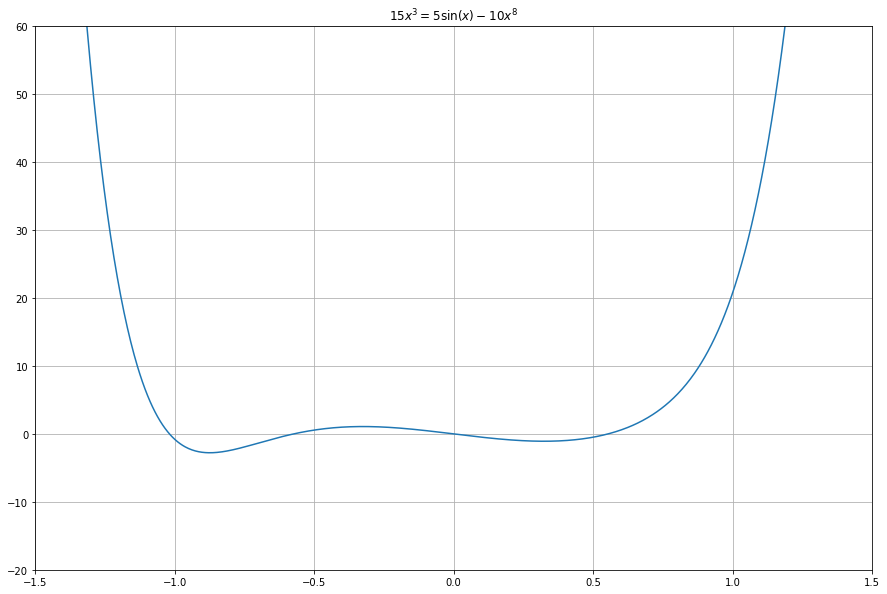

In [23]:
# Generate an array of 1000 evenly-spaced points from -1.5 to 1.5
x = np.linspace(-1.5,1.5,1000)
plt.figure(figsize=[15,10])
plt.plot(x,f(x))
plt.xlim([-1.5,1.5])
plt.ylim([-20,60])
plt.grid('on');
plt.title('$15x^3=5\sin(x)-10x^8$')

By inspecting the graph, we find out that the function $15x^3=5\sin(x)-10x^8$ crosses the x-axis 4 times on the x-interval [-1.5,1.5]. Reading the roots from left to right, the locations of the roots are approximately at $x=-1.1$, $x=-0.6$, $x=0.0$ and $x=0.6$.

#### Step 3: Use `fsolve` to calculate the roots

Now, let's use `scipy.optimize.fsolve` to find the exact locations of these 4 roots:

In [24]:
# guess of the first root is at x=-1.1
root_1=opt.fsolve(f,-1)
print(root)

[-1.01875397]


In [26]:
# guess of the second root is at x=-0.6
root_2=opt.fsolve(f,-0.5)
print(root_2)

[-0.57355768]


In [28]:
# guess of the third root is at x=0.0
root_3=opt.fsolve(f,0.0)
print(root_3)

[ 0.]


In [29]:
# guess of the fourth root is at x=0.6
root_4=opt.fsolve(f,0.6)
print(root_4)

[ 0.55319189]


#### Conclusion:

We find that the roots of the function $15x^3=5\sin(x)-10x^8$ are exactly the same as what we have expected. The exact locations of these roots are approximately at $x=-1.019$, $x=-0.574$, $x=0.0$, and $x=0.553$.

## 3. Exercises

**Exercise 1: USB Manufacturing**

A small company manufactures two electronic components, plastic cases for USB drives with two ports and cases with one port. Each two-port case takes 2 hours to assemble, whereas a one port case requires 1 hour. There are a maximum of 50 hours of labor dedicated for the day. The cost of materials for two-port case is $\$$1; the material for a one-port case costs $\$$2. Production only allows a maximum of $\$$70 per day. Each two-case port earns a profit of $\$$4 and each one-port case $\$$5. 

Find the number of two-port cases and one-port cases produced that will **maximize** the profit. Use `scipy.optimize.linprog` to check if "the number of two-port cases is 20 and the number of one-port cases is 15" is the optimal solution.


**Exercise 2: Gas Blending**

A company needs to blend 4000 barrels of aviation gas from three available components: Toluene, Alkylate and Pentane. The prices and certain constraints which must be satisfied by the blend are summarized in the following table:

Constraint|Toluene|Alkylate|Pentane|Specification
--- | --- | ---| ---| ---
$\%$ aromatics | 100 | 0 |0 | 5 (min)
Reid Vapor Pressue| 2.0  | 4.8 | 19.7| 5.5(min),7.0(max)
Performance Number| 100 | 125 |125 | 115 (max)
Cost ($\$$) per Barrel| 45| 30 |30 | 
Use `scipy.optimize.linprog` to find the amount of each resource to use in order to **minimize** the cost of producing the aviation gas.

**Exercise 3. Pig Farming**
![Pig](http://www.lmo.dk/Admin/Public/GetImage.ashx?Image=/Files/Images/1200x300%20Topbanner-slider/Gris%201200%20x%20300%20topbannerny.jpg&Format=jpg&Width=1200&Compression=75&DoNotUpscale=True)

You are the owner of a pig farm and you are looking for the cheapst way to feed your pigs and at the same time your pigs need to get all the nutrition they need. Consider three types of food and their nutritional values, prices, and the pigs' daily requirements as the following: 

|Corn|Silage|Alfalfa|Daily Requirement 
--- | --- | ---| ---| ---
Carbs | 0.9 | 0.2 |0.4 | 2 
Protein| 3  | 8| 6| 18
Vitamins| 1 | 2 |4 | 15
Cost | 7| 6 |5 | 

What is the best way to **minimize** the cost of feeding your pigs? Use `scipy.optimize.linprog` to find the optimal solution.

**Exercise 4.**
Given the function $$11x^5+3x^4=2\cos(x)+5$$
Plot the function out first using matplotlib. Then use `scipy.optimize.fsolve` to find the roots of this function by taking the equation to its canonical form. Check if the roots shown on the graph corresponds to your calculations. Keep in mind that you need to adjust your starting estimate in order to find all roots of the function.



## 4. Additional Resources

The following resources are available if you are interested in learning more about the subpackge `scipy.optimize`:

1. [Optimization Reference Guide](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html)

2. [SciPy Beginner's Guide for Optimization](https://www.youtube.com/watch?v=cXHvC_FGx24)

3. [Python Nonlinear Equations with SciPy fsolve](https://www.youtube.com/watch?v=v4R6K4RxADE)

4. [Mathematical Optimization](http://www.scipy-lectures.org/advanced/mathematical_optimization/)